## **0.ИМПОРТ БИБЛИОТЕК**

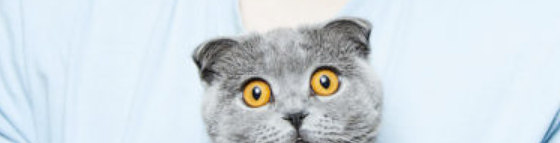

CPU times: total: 15.6 ms
Wall time: 1.99 ms


In [8]:
%%time
import pandas as pd
import numpy as np
import datetime as dt

import requests
from bs4 import BeautifulSoup
import io
import os
import time
from moexalgo import Ticker
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore');

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 2)

from IPython.display import display, Image
image_path = "img/1_.png"
display(Image(filename=image_path))

## 1 **ЗАГРУЗКА ДАННЫХ**


### 1.1 Загрузка. Тикеры ТОП-10 компаний ММВБ по капитализации 2023г.

In [3]:
# Загрузим тикеры топ-10 компаний ММВБ по капитализации 2023г.
URL = 'https://smart-lab.ru/q/shares_fundamental/?field=market_cap'
data = requests.get(URL).text
beautiful_soup = BeautifulSoup(data, 'html.parser')
tables = beautiful_soup.find_all('table')
top10 = pd.read_html(str(tables), index_col='№')[0].iloc[:10,[0, 1, 4]]
stock_list = top10['Тикер'].to_list()
top10.head(3)


,Название,Тикер,"Капитализация, млрд руб"
№,,,
1,Сбербанк,SBER,6 607
2,Роснефть,ROSN,6 009
3,Лукойл,LKOH,4 931


### 1.2 Загрузка. Котировки компаний через API MOEX

In [29]:
%%time
# Загрузим данные котировок компаний (5min 8s)
# API MOEX выдает не более 20 тыс строк за раз, PS команды https://github.com/moexalgo/moexalgo/blob/main/samples/quick_start.ipynb
STOCK_LIST = top10['Тикер'].to_list()
TIMEFRAME = 'h'
START_DATE = 2015
STOP_DATE = pd.Timestamp.now()
os.makedirs('data', exist_ok=True)

def downloader(TICKER):
    #Инициализация
    data = Ticker(TICKER).candles(date=pd.to_datetime(str(START_DATE)), till_date=STOP_DATE, period='1' + TIMEFRAME)
    for i in range(0, 100000):

        # Шаг вперед чтобы избежать наслоение периодов
        current_date = data.begin.max() + pd.Timedelta(1, unit=TIMEFRAME)
        df = Ticker(TICKER).candles(date=current_date, till_date=STOP_DATE, period='1' + TIMEFRAME)
        if df.empty:
            break

        # Объединяем в один
        data = pd.concat([data, df], ignore_index=True)
        print(f'{i+1}. {TICKER} - выполнение до {data.begin.max().date()}, осталось {(pd.Timestamp.now() - data.begin.max()).days} дней \nТекущий датасет {len(data)} строк\n')

    # Сохраним 
    path_data = f'data/{TICKER.lower()}_{TIMEFRAME}_{pd.to_datetime(str(START_DATE)).year}-{STOP_DATE.year}.csv'
    company_name = top10.set_index('Тикер').loc[TICKER]['Название']
    print(f'{company_name} загружен! Файл {path_data}\n')
    data.to_csv(path_data)
    print("------------------------------------------------------")

for TICKER in STOCK_LIST:
    downloader(TICKER)

1. SBER - выполнение до 2022-02-07, осталось 750 дней 
Текущий датасет 20000 строк

2. SBER - выполнение до 2024-02-27, осталось 0 дней 
Текущий датасет 26962 строк

Сбербанк загружен! Файл data/sber_h_2015-2024.csv

------------------------------------------------------
1. ROSN - выполнение до 2022-02-07, осталось 750 дней 
Текущий датасет 20000 строк

2. ROSN - выполнение до 2024-02-27, осталось 0 дней 
Текущий датасет 26957 строк

Роснефть загружен! Файл data/rosn_h_2015-2024.csv

------------------------------------------------------
1. LKOH - выполнение до 2022-02-07, осталось 750 дней 
Текущий датасет 20000 строк

2. LKOH - выполнение до 2024-02-27, осталось 0 дней 
Текущий датасет 26958 строк

Лукойл загружен! Файл data/lkoh_h_2015-2024.csv

------------------------------------------------------
1. NVTK - выполнение до 2022-02-14, осталось 744 дней 
Текущий датасет 20000 строк

2. NVTK - выполнение до 2024-02-27, осталось 0 дней 
Текущий датасет 26880 строк

НОВАТЭК загружен! Фа

### 1.3 Загрузка дивидендной истории компаний

In [30]:
%%time
# Загрузим дивидендные истории компаний 
for ticker in tqdm(stock_list, desc='Выполнение'):
    print(f'{ticker}')
    
    # Загрузка
    data = requests.get(f'https://www.dohod.ru/ik/analytics/dividend/{ticker.lower()}').text
    beautiful_soup = BeautifulSoup(data, 'html.parser')
    tables = beautiful_soup.find_all('table')

    # Исправляем данные
    dividends = pd.read_html(str(tables))[2] \
                                    .iloc[:,[0,1,3]] # Фильтр колонок
    dividends.iloc[:,:2] = dividends.iloc[:,:2] \
                                    .applymap(lambda x: str(x).rstrip(' (прогноз)') ) # Исправляем
    dividends.iloc[:,:2] = dividends.iloc[:,:2] \
                                    .applymap(lambda x: pd.to_datetime(x).date()) # Исправляем
    to_export_prophet = dividends.rename(columns={
                                    'Дата закрытия реестра':'ds',
                                    'Дивиденд':'y'}) # Приводим к виду
    to_export_prophet.iloc[:,:2] = to_export_prophet \
                                    .iloc[:,:2] \
                                    .applymap(lambda x: pd.to_datetime(x)                        
                                    .to_period('Q') \
                                    .end_time if pd.isna(x) != True else x) # Исправляем даты
    dividends.columns = ['Объяв. див.', 'Закр. реестра', 'Дивиденд'] # Сократим имя колонок
    # # Обучаем модель
    # model = Prophet()
    # model.fit(to_export_prophet[['ds', 'y']])

    # future = model.make_future_dataframe(periods=10, freq='Q')
    # to_export_prophet = model.predict(future)
    
    # # Экспортируем отдельно предсказанные данные 
    # path = f'export\streamlit\{ticker.lower()}_forcast_dividend.csv'
    # to_export_prophet.to_csv(path)
    # print(f'Прогноз дивидендов готов! Файл {path}')

    # Экспорт
    path = f'export\streamlit\{ticker.lower()}_dividend_table.csv'
    dividends.to_csv(path)
    print(f'Див история готова! Файл {path}')
    print("------------------------------------------------------")

Выполнение:   0%|          | 0/10 [00:00<?, ?it/s]

SBER


Выполнение:   0%|          | 0/10 [00:31<?, ?it/s]


ValueError: No tables found

### 1.3 Загрузим квартальные данные компаний и выделим наиболее значимые фундаментальные метрики, их корреляцию с капитализацией компании и их прогнозируемость через нормализованный RMSE

In [34]:
%%time
# Загрузим данные квартальных отчетностей 
# Выделим наиболее значимые фундаментальные метрики, их корреляцию с капитализацией компании и нормализованный RMSE
for ticker in tqdm(stock_list, desc='Выполнение '):
    print(f'{ticker} старт') # Строка состояния
    
    # Загрузка
    response = requests.get(f'https://smart-lab.ru/q/{ticker}/f/q/MSFO/download/')
    income_ = pd.read_csv(io.BytesIO(response.content), sep=';')
    
    # Исправляем данные 
    income_ = income_.T.iloc[:-1]
    income_.columns = income_.iloc[0]
    income_.reset_index(inplace=True)
    income_ = income_.iloc[1:]
    income_['index'] = pd.to_datetime(income_['index']) \
                            .dt.to_period('Q') \
                            .dt.end_time

    # Наиболее значимые фундаментальные метрики, их корреляцию с капитализацией компании и нормализованный RMSE
    most_important_params(income_=income_,ticker=ticker)
    export_statment_data(income_=income_,ticker=ticker)
    time.sleep(1)
    print("------------------------------------------------------\n")

# Наиболее значимые фундаментальные метрики, их корреляцию с капитализацией компании и нормализованный RMSE
def most_important_params(income_, ticker):
    
    # Исправляем данные
    income_ = income_.apply(lambda x: x.str.replace(',', '') 
                            if not pd.api.types.is_datetime64_any_dtype(x) 
                            else x) # Удаляем запятые
    income_ = income_.apply(lambda x: x.str.replace('%', '') 
                            if not pd.api.types.is_datetime64_any_dtype(x) 
                            else x) # Удаляем проценты
    income_ = income_.drop(['IR рейтинг', 'Качество фин.отчетности', 'Презентации для инвесторов',
                            'Присутствие на смартлабе', 'Годовой отчет', 'Сайт для инвесторов',
                            'Календарь инвесторов', 'Обратная связь', 'Дата отчета', 'Валюта отчета'],
                            axis=1) \
                            .apply(lambda x: x.str.replace(' ', '') \
                            .astype(float)  
                            if not pd.api.types.is_datetime64_any_dtype(x) 
                            else x) # Фильтр столбцов и исправляем строковые числа
    # Исправляем данные
    filtered_columns = income_.columns[income_.notna().sum() > 10] # Фильтр по пропускам данных
    correlation = income_[filtered_columns] \
                            .corr()['Капитализация, млрд руб'] \
                            .abs() \
                            .sort_values(ascending=False) # Выделим корреляцию только с капитализацией
    # Инициализация общего датасета
    result_df = pd.DataFrame(columns=['Корреляция', 'normalized_rmse'])
    # Выделим насколько прогнозируемы скореллированные параметры через RMSE: 
    best_columns = correlation.filter(regex='^(?!Цена акции|Капитализация|index)').head(10)
    for column in best_columns.index:
    
        # Разбиваем train test
        data = income_[['index', column]].rename(columns={'index': 'ds', column: 'y'}).dropna()
        split_train = int(0.8 * len(data))  # 80% для обучения 
        train_data, test_data = data[:split_train], data[split_train:]

        model = Prophet()
        model.fit(train_data)
        future = model.make_future_dataframe(periods=len(test_data))
        forecast = model.predict(future)
        
        # Приводим RMSE различных параметров к одному порядку
        rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'][-len(test_data):]))
        mean_target = test_data['y'].mean()
        normalized_rmse = rmse / mean_target
        result_df.loc[column] = [correlation[column], normalized_rmse]
         
    # Комбинируем RMSE и Корреляцию в один признак ранжирования лучших признаков
    result_df['normalized_rmse'] = 1 - (result_df['normalized_rmse'] / result_df['normalized_rmse'].max()) # Нормализуем и инвертируем
    result_df['combined_score'] = result_df['normalized_rmse'] * result_df['Корреляция'] # Объединим
    result_df = result_df.sort_values('combined_score', ascending=False) # Сортируем

    # Экспорт
    path = f'export\streamlit\{ticker.lower()}_correlation_table.csv'
    result_df.to_csv(path)
    print(f'\nКоррелирующие параметры выделены. Файл {path}')
    return correlation

# Экспорт кварт. отчетностей
def export_statment_data(income_, ticker):
    income_ = income_[['index','Чистая прибыль, млрд руб',
                       'Капитализация, млрд руб','P/E']].dropna()
    income_ = income_.rename(columns={'index':'ds',
                                      'Чистая прибыль, млрд руб':'y'})
    income_[['y', 'Капитализация, млрд руб']] = income_[['y', 'Капитализация, млрд руб']] \
                                                        .apply(lambda x: x.str.replace(' ', '').astype(float))
    # Экспорт
    path = f'export\streamlit\{ticker.lower()}_income.csv'
    income_.to_csv(path)
    print(f'Отчетность выгружена. Файл {path}')
    
    export_forecast_income(income_, ticker)

# Прогноз дохода компаний
def export_forecast_income(income_,ticker):

    # Обучение
    p = Prophet()
    p.fit(income_[['ds', 'y']])
    future = p.make_future_dataframe(periods=10, freq='Q')
    forecast_income = p.predict(future)

    # Экспорт
    path = f'export\streamlit\{ticker.lower()}_forcast_income.csv'
    forecast_income.to_csv(path)
    print(f'Прогноз дохода выполнен! Файл {path}\n')

Выполнение :   0%|          | 0/10 [00:00<?, ?it/s]

SBER старт


08:22:57 - cmdstanpy - INFO - Chain [1] start processing
08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing
08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing
08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing
08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing
08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing
08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing
08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:59 - cmdstanpy - INFO - Chain [1] start processing
08:22:59 - cmdstanpy - INFO - Chain [1] done processing
08:22:59 - cmdstanpy - INFO - Chain [1] start processing
08:22:59 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\sber_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"EV, млрд руб",0.92,0.86,0.79
"Чист. комисс. доход, млрд руб",0.81,0.96,0.78
...,...,...,...
"Расх на персонал, млрд руб",0.87,0.23,0.20
"Дост.осн капитала, %",0.79,0.00,0.00


08:22:59 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\sber_income.csv


08:23:00 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\sber_forcast_income.csv



Выполнение :  10%|█         | 1/10 [00:05<00:46,  5.19s/it]

------------------------------------------------------

ROSN старт


08:23:02 - cmdstanpy - INFO - Chain [1] start processing
08:23:02 - cmdstanpy - INFO - Chain [1] done processing
08:23:02 - cmdstanpy - INFO - Chain [1] start processing
08:23:02 - cmdstanpy - INFO - Chain [1] done processing
08:23:02 - cmdstanpy - INFO - Chain [1] start processing
08:23:02 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:04 - cmdstanpy - INFO - Chain [1] start processing
08:23:04 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\rosn_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Активы, млрд руб",0.86,0.93,0.80
"Чистые активы, млрд руб",0.79,0.91,0.72
...,...,...,...
"ROA, %",0.67,0.56,0.37
"FCF/акцию, руб",0.65,0.00,0.00


08:23:04 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\rosn_income.csv


08:23:04 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\rosn_forcast_income.csv



Выполнение :  20%|██        | 2/10 [00:09<00:38,  4.83s/it]

------------------------------------------------------

LKOH старт


08:23:06 - cmdstanpy - INFO - Chain [1] start processing
08:23:07 - cmdstanpy - INFO - Chain [1] done processing
08:23:07 - cmdstanpy - INFO - Chain [1] start processing
08:23:13 - cmdstanpy - INFO - Chain [1] done processing
08:23:13 - cmdstanpy - INFO - Chain [1] start processing
08:23:13 - cmdstanpy - INFO - Chain [1] done processing
08:23:13 - cmdstanpy - INFO - Chain [1] start processing
08:23:13 - cmdstanpy - INFO - Chain [1] done processing
08:23:13 - cmdstanpy - INFO - Chain [1] start processing
08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing
08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing
08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing
08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing
08:23:15 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\lkoh_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Персонал, чел",0.77,1.00,0.77
"EV, млрд руб",0.99,0.78,0.77
...,...,...,...
"ROE, %",0.72,0.08,0.06
"Доходность FCF, %",0.74,0.00,0.00


08:23:15 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\lkoh_income.csv


08:23:15 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\lkoh_forcast_income.csv



Выполнение :  30%|███       | 3/10 [00:20<00:53,  7.69s/it]

------------------------------------------------------

NVTK старт


08:23:18 - cmdstanpy - INFO - Chain [1] start processing
08:23:18 - cmdstanpy - INFO - Chain [1] done processing
08:23:18 - cmdstanpy - INFO - Chain [1] start processing
08:23:18 - cmdstanpy - INFO - Chain [1] done processing
08:23:18 - cmdstanpy - INFO - Chain [1] start processing
08:23:18 - cmdstanpy - INFO - Chain [1] done processing
08:23:19 - cmdstanpy - INFO - Chain [1] start processing
08:23:19 - cmdstanpy - INFO - Chain [1] done processing
08:23:19 - cmdstanpy - INFO - Chain [1] start processing
08:23:19 - cmdstanpy - INFO - Chain [1] done processing
08:23:19 - cmdstanpy - INFO - Chain [1] start processing
08:23:19 - cmdstanpy - INFO - Chain [1] done processing
08:23:19 - cmdstanpy - INFO - Chain [1] start processing
08:23:20 - cmdstanpy - INFO - Chain [1] done processing
08:23:20 - cmdstanpy - INFO - Chain [1] start processing
08:23:20 - cmdstanpy - INFO - Chain [1] done processing
08:23:20 - cmdstanpy - INFO - Chain [1] start processing
08:23:20 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\nvtk_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Активы, млрд руб",0.80,0.98,0.78
"Чистые активы, млрд руб",0.84,0.87,0.73
...,...,...,...
"BV/акцию, руб",0.69,0.16,0.11
"Баланс стоимость, млрд руб",0.71,0.00,0.00


08:23:21 - cmdstanpy - INFO - Chain [1] start processing
08:23:21 - cmdstanpy - INFO - Chain [1] done processing


Отчетность выгружена. Файл export\streamlit\nvtk_income.csv
Прогноз дохода выполнен! Файл export\streamlit\nvtk_forcast_income.csv



Выполнение :  40%|████      | 4/10 [00:26<00:40,  6.82s/it]

------------------------------------------------------

GAZP старт


08:23:23 - cmdstanpy - INFO - Chain [1] start processing
08:23:23 - cmdstanpy - INFO - Chain [1] done processing
08:23:23 - cmdstanpy - INFO - Chain [1] start processing
08:23:23 - cmdstanpy - INFO - Chain [1] done processing
08:23:24 - cmdstanpy - INFO - Chain [1] start processing
08:23:24 - cmdstanpy - INFO - Chain [1] done processing
08:23:24 - cmdstanpy - INFO - Chain [1] start processing
08:23:24 - cmdstanpy - INFO - Chain [1] done processing
08:23:24 - cmdstanpy - INFO - Chain [1] start processing
08:23:24 - cmdstanpy - INFO - Chain [1] done processing
08:23:24 - cmdstanpy - INFO - Chain [1] start processing
08:23:25 - cmdstanpy - INFO - Chain [1] done processing
08:23:25 - cmdstanpy - INFO - Chain [1] start processing
08:23:25 - cmdstanpy - INFO - Chain [1] done processing
08:23:25 - cmdstanpy - INFO - Chain [1] start processing
08:23:25 - cmdstanpy - INFO - Chain [1] done processing
08:23:25 - cmdstanpy - INFO - Chain [1] start processing
08:23:25 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\gazp_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Чистые активы, млрд руб",0.56,0.95,0.53
"Активы, млрд руб",0.76,0.66,0.50
...,...,...,...
"R&D/CAPEX, %",0.56,0.30,0.16
"EBITDA, млрд руб",0.45,0.00,0.00


08:23:26 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\gazp_income.csv


08:23:26 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\gazp_forcast_income.csv



Выполнение :  50%|█████     | 5/10 [00:31<00:30,  6.15s/it]

------------------------------------------------------

SIBN старт


08:23:28 - cmdstanpy - INFO - Chain [1] start processing
08:23:28 - cmdstanpy - INFO - Chain [1] done processing
08:23:29 - cmdstanpy - INFO - Chain [1] start processing
08:23:29 - cmdstanpy - INFO - Chain [1] done processing
08:23:29 - cmdstanpy - INFO - Chain [1] start processing
08:23:29 - cmdstanpy - INFO - Chain [1] done processing
08:23:29 - cmdstanpy - INFO - Chain [1] start processing
08:23:29 - cmdstanpy - INFO - Chain [1] done processing
08:23:29 - cmdstanpy - INFO - Chain [1] start processing
08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing
08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing
08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing
08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing
08:23:31 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\sibn_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Операционный денежный поток, млрд руб",0.79,0.84,0.66
"Выручка, млрд руб",0.88,0.69,0.61
...,...,...,...
"EBITDA, млрд руб",0.74,0.03,0.02
P/BV,0.83,0.00,0.00


08:23:31 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\sibn_income.csv


08:23:31 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\sibn_forcast_income.csv



Выполнение :  60%|██████    | 6/10 [00:36<00:23,  5.88s/it]

------------------------------------------------------

GMKN старт


08:23:34 - cmdstanpy - INFO - Chain [1] start processing
08:23:34 - cmdstanpy - INFO - Chain [1] done processing
08:23:34 - cmdstanpy - INFO - Chain [1] start processing
08:23:34 - cmdstanpy - INFO - Chain [1] done processing
08:23:34 - cmdstanpy - INFO - Chain [1] start processing
08:23:34 - cmdstanpy - INFO - Chain [1] done processing
08:23:34 - cmdstanpy - INFO - Chain [1] start processing
08:23:34 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing
08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing
08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing
08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing
08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing
08:23:35 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\gmkn_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Выручка, млрд руб",0.86,0.98,0.85
"EBITDA, млрд руб",0.84,0.88,0.74
...,...,...,...
"Доходность FCF, %",0.73,0.80,0.58
P/BV,0.75,0.00,0.00


08:23:36 - cmdstanpy - INFO - Chain [1] start processing
08:23:36 - cmdstanpy - INFO - Chain [1] done processing


Отчетность выгружена. Файл export\streamlit\gmkn_income.csv
Прогноз дохода выполнен! Файл export\streamlit\gmkn_forcast_income.csv



Выполнение :  70%|███████   | 7/10 [00:41<00:16,  5.51s/it]

------------------------------------------------------

TATN старт


08:23:38 - cmdstanpy - INFO - Chain [1] start processing
08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:39 - cmdstanpy - INFO - Chain [1] start processing
08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:39 - cmdstanpy - INFO - Chain [1] start processing
08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:39 - cmdstanpy - INFO - Chain [1] start processing
08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:39 - cmdstanpy - INFO - Chain [1] start processing
08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing
08:23:40 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing
08:23:40 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing
08:23:40 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing
08:23:40 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\tatn_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
P/BV,0.92,0.72,0.66
"Операционный денежный поток, млрд руб",0.79,0.84,0.66
...,...,...,...
"ROA, %",0.60,0.57,0.34
"Долг, млрд руб",0.67,0.00,0.00


08:23:41 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\tatn_income.csv


08:23:41 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\tatn_forcast_income.csv



Выполнение :  80%|████████  | 8/10 [00:46<00:10,  5.30s/it]

------------------------------------------------------

SNGS старт


08:23:43 - cmdstanpy - INFO - Chain [1] start processing
08:23:43 - cmdstanpy - INFO - Chain [1] done processing
08:23:43 - cmdstanpy - INFO - Chain [1] start processing
08:23:43 - cmdstanpy - INFO - Chain [1] done processing
08:23:43 - cmdstanpy - INFO - Chain [1] start processing
08:23:43 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing
08:23:45 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\sngs_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"Чистый долг, млрд руб",0.40,1.60,0.65
"Чистые активы, млрд руб",0.40,0.94,0.38
...,...,...,...
"BV/акцию, руб",0.49,0.00,0.00
"Баланс стоимость, млрд руб",0.49,0.00,0.00


08:23:45 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\sngs_income.csv


08:23:45 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\sngs_forcast_income.csv



Выполнение :  90%|█████████ | 9/10 [00:50<00:04,  4.98s/it]

------------------------------------------------------

PLZL старт


08:23:47 - cmdstanpy - INFO - Chain [1] start processing
08:23:47 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing
08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing
08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing
08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing
08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing
08:23:49 - cmdstanpy - INFO - Chain [1]


Коррелирующие параметры выделены. Файл export\streamlit\plzl_correlation_table.csv


,Корреляция,normalized_rmse,combined_score
"EV, млрд руб",0.99,0.87,0.86
"Рентаб EBITDA, %",0.87,0.97,0.84
...,...,...,...
"Доходность FCF, %",0.70,0.72,0.50
"FCF, млрд руб",0.77,0.00,0.00


08:23:50 - cmdstanpy - INFO - Chain [1] start processing


Отчетность выгружена. Файл export\streamlit\plzl_income.csv


08:23:50 - cmdstanpy - INFO - Chain [1] done processing


Прогноз дохода выполнен! Файл export\streamlit\plzl_forcast_income.csv



Выполнение : 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]

------------------------------------------------------



In [35]:
# Визуализация
# Выберем лучшие 10 параметров
best_columns = correlation.head(10).index
selected_columns = income_[best_columns]
correlation_matrix = selected_columns.corr()

# Уберем все строки, кроме строки с 'Капитализация, млрд руб'
correlation_with_capitalization = correlation_matrix[['Капитализация, млрд руб']]

# Построим тепловую карту
plt.figure(figsize=(2, 4))  # Изменяем размер, чтобы было место только для одной строки
sns.heatmap(correlation_with_capitalization, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("Тепловая карта корреляции лучших параметров с 'Капитализация, млрд руб'")
plt.show()

NameError: name 'correlation' is not defined

## 2 **ТАБЛИЦА ПРОГНОЗОВ ЦЕН АКЦИЙ**
- Для каждой компании из набора данных прогнозируем цену акции на основе исторических данных, а затем создаем общую таблицу, в которой содержится суммарная информация о прогнозах для всех компаний. 
- Эта таблица включает - текущая цена акции, прогнозируемая цена акции на последний день прогноза, нижняя и верхняя границы прогноза, а также потенциальный риск и процент изменения цены акции.







In [37]:
%%time
# Объединение данных прогноза в одну таблицу, как расширенная информация основного графика страницы
# Цикл по файлам в папке
for file_in_folder in tqdm(os.listdir('data/'), desc='Моделирование прогноза ', unit='file'):
    file_ = pd.read_csv('data/' + file_in_folder)
    price = file_.iloc[-1]['close']
    name = file_in_folder.split('_')[0]
    
    # Импорт данных и обучение модели
    df = pd.DataFrame()
    df['ds'], df['y'] = pd.to_datetime(file_.begin), file_['close']

    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=300)  # прогноз на 300 дней вперед
    forecast = model.predict(future)

    # Добавим информацию о каждом активе на последний день прогноза
    last_pred_day = forecast.iloc[-1]
    sums_ = []
    sums_.append({
            'name': name,
            'price': price,
            'predicted_price': last_pred_day['yhat'],
            'lowest' : last_pred_day['yhat_lower'],
            'highest' : last_pred_day['yhat_upper'],})

    # Экспорт
    os.makedirs('export/streamlit', exist_ok=True)
    forecast.to_csv(f'export/streamlit/{name}_forecast.csv')
    print(f'{name.upper()} завершен!\n') # Строка процесса
    
# Объединим в один DataFrame
sums_ = pd.DataFrame(sums_)
sums_.set_index('name', inplace=True)

prediction_duration = (pd.to_datetime(sums_.predicted_date) - pd.to_datetime(sums_.date)) / pd.to_timedelta(365, unit='D') # Промежуточный параметр
potential_risk = (sums_.lowest - sums_.price).mul(100) / sums_['price'] # Промежуточный параметр

sums_['potential_risk'] = potential_risk / prediction_duration # Процент потенциального риска, вычисляемый как процентное изменение между нижней границей прогноза и текущей ценой актива.
sums_['%_change'] = (sums_.predicted_price - sums_.price).mul(100) / sums_.price # Процентное изменение прогнозируемой цены по сравнению с текущей ценой.

# Экспорт
path = r'export/streamlit/00_sums_data.csv'
sums_.to_csv(path)
print(f'Общий файл сформирован: {path}')
sums_.head(3)


Моделирование прогноза :   0%|          | 0/10 [00:00<?, ?file/s]08:55:10 - cmdstanpy - INFO - Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  10%|█         | 1/10 [00:28<04:12, 28.01s/file]

GAZP завершен!



08:55:38 - cmdstanpy - INFO - Chain [1] start processing
08:56:11 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  20%|██        | 2/10 [01:07<04:40, 35.05s/file]

GMKN завершен!



08:56:18 - cmdstanpy - INFO - Chain [1] start processing
08:56:55 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  30%|███       | 3/10 [01:51<04:32, 38.97s/file]

LKOH завершен!



08:57:01 - cmdstanpy - INFO - Chain [1] start processing
08:57:39 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  40%|████      | 4/10 [02:35<04:06, 41.08s/file]

NVTK завершен!



08:57:46 - cmdstanpy - INFO - Chain [1] start processing
08:58:23 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  50%|█████     | 5/10 [03:19<03:29, 41.86s/file]

PLZL завершен!



08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:56 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  60%|██████    | 6/10 [03:52<02:35, 38.93s/file]

ROSN завершен!



08:59:02 - cmdstanpy - INFO - Chain [1] start processing
08:59:37 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  70%|███████   | 7/10 [04:33<01:58, 39.55s/file]

SBER завершен!



08:59:43 - cmdstanpy - INFO - Chain [1] start processing
09:00:11 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  80%|████████  | 8/10 [05:07<01:15, 37.77s/file]

SIBN завершен!



09:00:17 - cmdstanpy - INFO - Chain [1] start processing
09:00:47 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза :  90%|█████████ | 9/10 [05:42<00:37, 37.14s/file]

SNGS завершен!



09:00:53 - cmdstanpy - INFO - Chain [1] start processing
09:01:22 - cmdstanpy - INFO - Chain [1] done processing
Моделирование прогноза : 100%|██████████| 10/10 [06:18<00:00, 37.89s/file]

TATN завершен!

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 37, in <module>
  File "C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\generic.py", line 6293, in __getattr__
    return object.__getattribute__(self, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'DataFrame' object has no attribute 'predicted_date'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.Interacti

## 3.0 **ГРАФИЧЕСКАЯ ТЕСТ ЧАСТЬ**
- Для LKOH построим два подграфика: один для отображения исторических данных и прогноза цены акций с доверительным интервалом, а другой для отображения объема торгов.

<Axes: xlabel='ds'>

<Axes: xlabel='ds'>

<Axes: xlabel='ds'>

<Axes: xlabel='ds'>

Text(2024-11-13 23:00:00, 9729.09664580563, '(2024-12-23, 9629 )')

Text(0.5, 1.0, 'Прогнозирование цены Лукойл')

(16801.0, 20240.0)

(2000.0, 10500.0)

(16801.0, 20240.0)

(0.0, 2157763.6)

<Axes: xlabel='ds'>

Text(0.5, 0, 'January 05. 2015 - December 23. 2024')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993., 19358.,
        19723., 20089.]),
 [Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

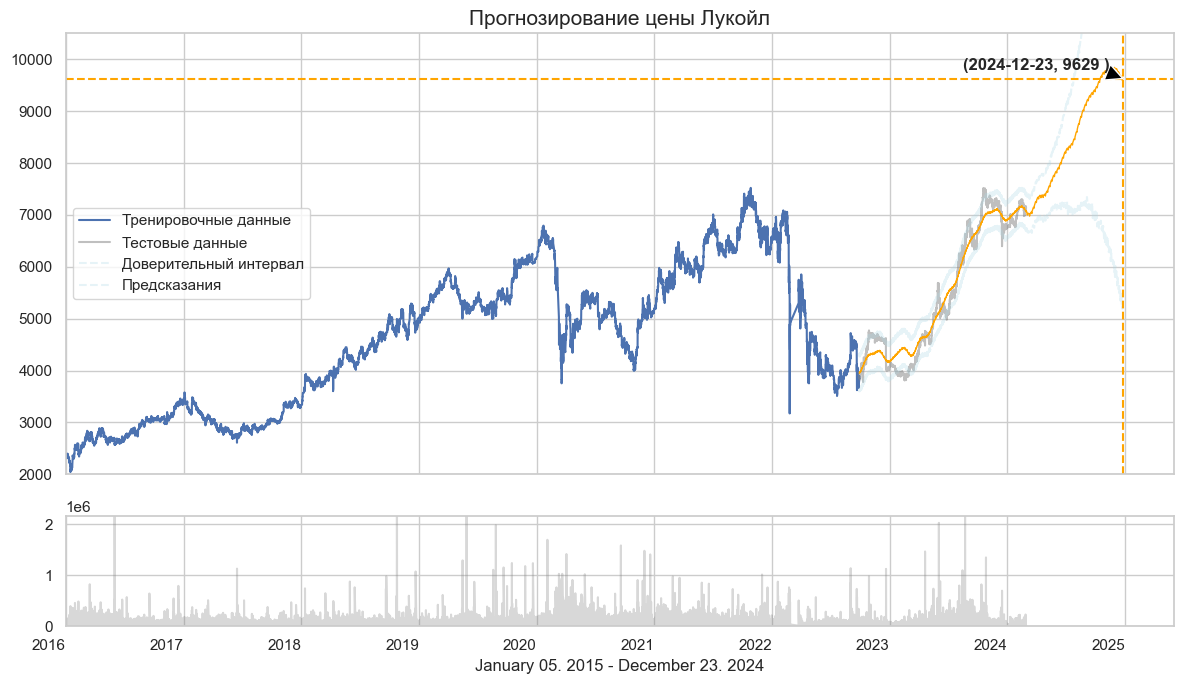

In [71]:
plot_df = pd.read_csv(r"data\lkoh_h_2015-2024.csv", 
                        index_col='Unnamed: 0', 
                        parse_dates=['begin', 'end']) \
                        .rename({'begin':'ds'}, axis=1)
forecast = pd.read_csv(r"export\streamlit\lkoh_forecast.csv", 
                        index_col='Unnamed: 0', 
                        parse_dates=['ds'])

split = int(0.8*len(plot_df))
train_df, test_df = plot_df.iloc[:split], plot_df.iloc[split:]

# Создаем макета с двумя подграфиками
sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), 
                        gridspec_kw={'height_ratios': [4, 1]}, 
                        sharex=True)

# Нанесение графика и доверительного интервала
train_df.set_index('ds')['close'].plot(ax=ax1)
test_df.set_index('ds')['close'].plot(ax=ax1, 
                        color='grey',
                        alpha=0.5)

# Нижняя и верхняя границы прогноза
forecast[['yhat_lower', 'yhat_upper', 'ds']] \
                        .set_index('ds')[train_df.index.max():] \
                        .plot(ax=ax1, 
                        color='lightblue', 
                        alpha=0.3, 
                        linestyle='--')

# Основная линия прогноза
forecast[['yhat', 'ds']].set_index('ds')[train_df.index.max():] \
                        .plot(ax=ax1, 
                        color='orange', 
                        label='Предсказания', 
                        linewidth=1)

# Подписываем финальную точку предсказания
final_prediction = forecast.iloc[-1]
ax1.annotate(f'({final_prediction["ds"].date()}, {int(final_prediction["yhat"])} )', 
                        xy=(final_prediction["ds"], final_prediction["yhat"]), 
                        xytext=(final_prediction["ds"] - pd.Timedelta(days=40),final_prediction["yhat"]+100), 
                        fontsize=12,
                        weight='bold',
                        arrowprops=dict(facecolor='black', shrink=0), 
                        horizontalalignment='right',  # выравнивание по горизонтали
                        verticalalignment='bottom',  # выравнивание по вертикали
                        )

# Настройка легенды
ax1.legend(["Тренировочные данные", "Тестовые данные", 
            "Доверительный интервал", "Предсказания"])

# Пунктирные линии границ
ax1.axvline(future.iloc[-1].values, 
                        color='orange', 
                        ls='--', 
                        label=f'Граница прогнозирования')
ax1.axhline(forecast['yhat'].iloc[-1], 
                        color='orange', 
                        ls='--')

# Установка интервала осей, заголовка
ax1.set_title('Прогнозирование цены Лукойл', fontsize=15)
ax1.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2025-06-01'))
ax1.set_ylim(2000, 10500)
ax2.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2025-06-01'))
ax2.set_ylim(0, plot_df['volume'].max()*0.4) # Масштабируем шкалу объема

# Построение графика объемов на втором подграфике
plot_df.set_index('ds')['volume'] \
                        .plot(ax=ax2, 
                        color='grey', 
                        alpha=0.3)

# Установка параметров чертежа
plt.xlabel(f'{train_df.ds.dt.date.min().strftime("%B %d. %Y")} - {pd.to_datetime(future.iloc[-1].values).strftime("%B %d. %Y").item()}', fontsize=12) # Форматируемый диапазон дат под графиком
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
